# Steps to generate models

This notebook outlines steps for generating the pre-computed models provided with Dustapprox.

The process typically involves the following steps:
- download or provide atmosphere models
- select extinction curves
- select passbands to compute extinction in
- Generate a grid of models for various values of $A_0$ and $R_0$ (or other extinction curve parameters)
- Fit polynomial models to the extinction values as a function of $A_0$, $R_0$, and commonly $T_{eff}$ or colors.
- Export the models to ECSV files for later use.

```{admonition} version

This notebook is based on Dustapprox version 0.2.0.

```

```{warning}
This process can be computationally intensive and may take some time to complete.
```

```{admonition} Intermediate data not provided
We do not provide the intermediate data files (e.g., the atmosphere models or the full grid of extinction values before fitting) due to their large size. However, the code provided here allows you to reproduce the models if needed.
```

In [2]:
# import package or add to path from source
try:
    import dustapprox
except ImportError:
    import sys
    sys.path.insert(0, "../src")
    import dustapprox

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Available extinction curves

Dusapprox uses [`dust_extinction`](https://dust-extinction.readthedocs.io/en/latest/) as provider of dust extinction curves. [](#fig-extinction-curves) shows some of the available extinction curves. Not all extinction curves are suitable for all applications, weavelength ranges, parameters, etc vary between curves. We primarily use the [parametric average average curves](https://dust-extinction.readthedocs.io/en/latest/dust_extinction/choose_model.html#parameter-dependent-average-curves) here, but you can always manually use a different one. Please refer to the [`dust_extinction`](https://dust-extinction.readthedocs.io/en/latest/) documentation for more details.

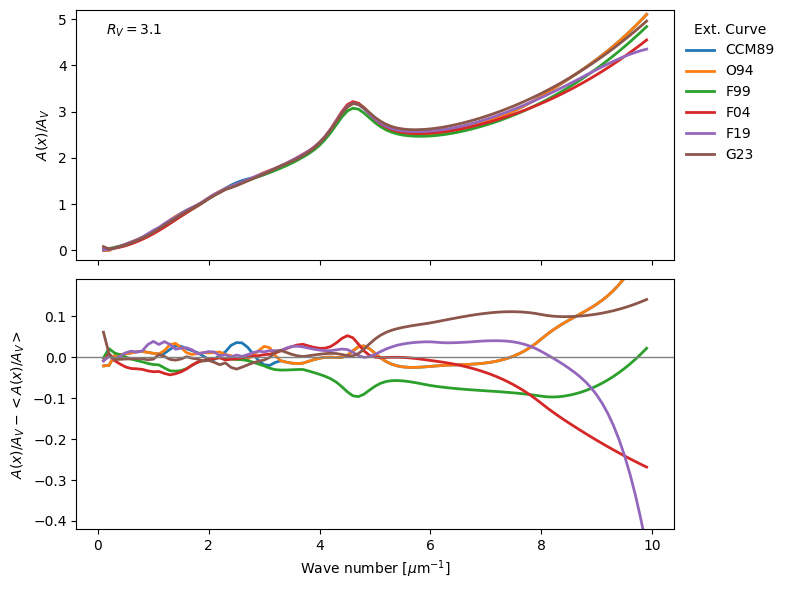

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from dustapprox.extinction import evaluate_extinction_model

#define the wave numbers
x = np.arange(0.1, 10, 0.1)    # in microns^{-1}
λ = 1. / x * u.micron

curves = 'CCM89', 'O94', 'F99', 'F04', 'F19', 'G23'
R0 = 3.1

curve_data = {}
_, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
for name in curves:
    values = evaluate_extinction_model(name, λ, A0=1.0, R0=R0)
    curve_data[name] = values
    axes[0].plot(x, values, label=f'{name:s}', lw=2)

mean_curve = np.nanmean(list(curve_data.values()), axis=0)
for name, values in curve_data.items():
    diff = values - mean_curve
    axes[1].plot(x, diff, label=f'{name:s}', lw=2)

axes[0].set_ylabel(r'$A(x)/A_V$')
axes[0].legend(loc='upper left', frameon=False, title=rf'Ext. Curve', bbox_to_anchor=(1.0, 1.0))
axes[0].text(0.05, 0.9, rf'$R_V={R0:.1f}$', transform=axes[0].transAxes)
axes[1].set_xlabel(r'Wave number [$\mu$m$^{-1}$]')
axes[1].set_ylabel(r'$A(x)/A_V - <A(x)/A_V>$')
axes[1].axhline(0.0, color='0.5', ls='-', lw=1)
axes[0].set_ylim(-0.2, 5.2)
axes[1].set_ylim(-0.42, 0.19)
plt.tight_layout()
plt.show()

```{seealso}

{doc}`extinction`

```

## Available passbands

For the photometry, we use [`pyphot`](https://mfouesneau.github.io/pyphot/index.html) a suite to compute synthetic photometry in flexible ways.

```{admonition} Using pyphot v2.0.0
:class: important

For more information about `pyphot`, and the internal photometric computations, please refer to its [documentation](https://mfouesneau.github.io/pyphot/index.html).

```

### Through the SVO Profile Service

{func}`dustapprox.io.svo.get_svo_passbands` is a wrapper around pyphot to interface the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/theory/fps/index.php), which provides us with a large collection of passbands. [](#fig-passbands) shows an example of passbands retrieved from the SVO service.

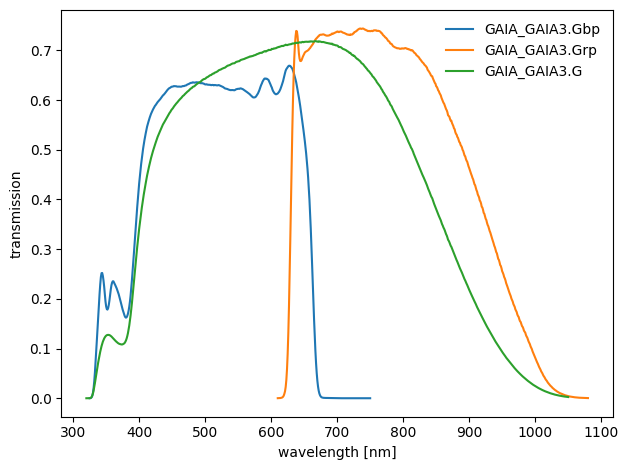

In [5]:
#| tags: [hide-input]
#| label: fig-passbands
#| caption: This figure shows the Gaia eDR3 passbands retrieved from the SVO service.
import matplotlib.pyplot as plt

from dustapprox.io import svo
which_filters = ['GAIA/GAIA3.Gbp', 'GAIA/GAIA3.Grp', 'GAIA/GAIA3.G']
passbands = svo.get_svo_passbands(which_filters)

for pb in passbands:
   plt.plot(pb.wavelength.to('nm'), pb.transmit, label=pb.name)

plt.legend(loc='upper right', frameon=False)

plt.xlabel('wavelength [nm]')
plt.ylabel('transmission')
plt.tight_layout()

### Passbands from local ascii files

Pyphot also provides all features to read passbands from local ascii files. [](#fig-gaiac1-passbands) shows an example of the Gaia C1 passbands ([Jordi et al 2006](https://academic.oup.com/mnras/article/367/1/290/1018790)) read from dustapprox distributed ascii files.
The C1B and C1M systems for the broad and medium band passbands, respectively. The C1 system was specifically designed to maximize the scientific return in terms of stellar astrophysical parameters, but was not implemented in favor of the Gaia BP/RP prism spectra.


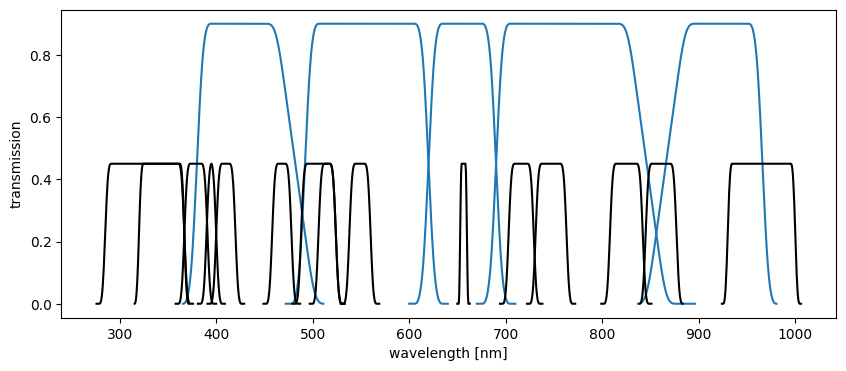

In [6]:
#| tags: [hide-input]
#| label: fig-gaiac1-passbands
#| caption: This figure shows the Gaia C1 passbands from dustapprox provided ascii files. The Broad passbands are shown in full strength, while the medium ones are shown at half strength for clarity.
from importlib import resources
from pyphot.libraries import Ascii_Library

# get the path to the data directory in the package
where = str(resources.files('dustapprox').joinpath('data/Gaia2'))

# load all filters from that directory
lib = Ascii_Library(where)
pbset = lib.load_filters(lib.find('C1'))

# plot the passbands
plt.figure(figsize=(10,4))
for pb in pbset:
    if pb.name.startswith("C1B"):
        scale = 1.
        color = 'C0'
        zorder = 1
    else:
        scale = 0.5
        color = 'k'
        zorder = 10
    plt.plot(pb.wavelength.to('nm'), 
             pb.transmit * scale, 
             label=pb.name, 
             color=color, 
             zorder=zorder)

plt.xlabel('wavelength [nm]')
plt.ylabel('transmission');

## Generating the pre-computed models

```{warning}
This process can be computationally intensive and may take some time to complete.
```

### define the set of filters you want to compute the models for. 

Here is an example of some commonly used sets of filters:

In [7]:
# List of common sets of filters we use to generate pre-computed models for dustapprox.

gaia_filters = ['GAIA/GAIA3.G', 'GAIA/GAIA3.Gbp', 'GAIA/GAIA3.Grp',]
sloan_filters = ['SLOAN/SDSS.u', 'SLOAN/SDSS.g', 'SLOAN/SDSS.r', 'SLOAN/SDSS.i', 'SLOAN/SDSS.z',]
twomass_filters = ['2MASS/2MASS.J', '2MASS/2MASS.H', '2MASS/2MASS.Ks',]
wise_filters = ['WISE/WISE.W1', 'WISE/WISE.W2', 'WISE/WISE.W3', 'WISE/WISE.W4',]
galex_filters = ['GALEX/GALEX.FUV', 'GALEX/GALEX.NUV',]
generic_filters = ['Generic/Johnson.U', 'Generic/Johnson.B', 'Generic/Johnson.V',
                   'Generic/Cousins.R', 'Generic/Cousins.I',
                   'Generic/Bessell_JHKLM.J', 'Generic/Bessell_JHKLM.H', 'Generic/Bessell_JHKLM.K',]

In the following, we will use the Gaia filters `gaia_filters` as an example.

### Define the atmosphere models. 

As internally we calculate the relative change in flux of the spectra, we do not need absolute flux-calibrated models and use the atmospheres directly (i.e. no rescaling with radius or bolometric luminosity). Here we use the Kurucz 2003 models taken from the [SVO Theoretical spectra](http://svo2.cab.inta-csic.es/theory/newov2/index.php) service. These models span ranges of from 3,500 K to 50,000 K, from 0 to 5 dex, and metallicity from -4 to 0 dex. Our approach is agnostics to the exact library itself. All files from SVO have the same format, but the spectra are not on the same wavelength scale (even for a single atmosphere source). The parameters of the spectra may vary from source to source. For instance, they may not provide microturbulence velocity or [$\alpha$/Fe] etc. We technically require only effective temperature and surface gravity to be provided.

```{seealso}

{doc}`atmospheres` for further information and download links to some precompiled atmospheres.

```

The following code snippet shows how to generate the pre-computed models using the {func}`~dustapprox.tools.generate_model.generate_grid` function from {mod}`dustapprox.tools.generate_model` module. It is basically a loop over the model atmosphere files, the A0 and R0 values, and the selected filters.
The internal function {func}`~dustapprox.tools.generate_model.generate_grid` handles all the details of reading the atmosphere models, applying the extinction curves, computing synthetic photometry, and exporting the results to ECSV files. It also allows parallel processing through `joblib` to speed up the computation.

In [8]:
from dustapprox.tools import generate_model
import pathlib

# features = 'teff logg feh A0 alpha'.split()
features = "teff A0 R0".split()
model_pattern = "models/Kurucz2003all/*.fl.dat.txt"
# model_pattern = "../docs/models/Kurucz2003all/*.fl.dat.txt"
name = gaia_filters[0].split("/")[0].lower()
output_path = pathlib.Path(f"precomputed/grids/kurucz_{name}_f99_a0r0_grid.ecsv")
atmosphere_name = "Kurucz (ODFNEW/NOVER 2003)"
extinction_curve = "F99"

# Compute the grid -- this may take a while -- reuses existing grids if available
r = generate_model.generate_grid(
    model_pattern,
    output_path,
    gaia_filters,
    atmosphere_name=atmosphere_name,
    extinction_curve=extinction_curve,
    n_jobs=-1
)

Computing photometric grid
   - Using passbands: GAIA/GAIA3.G, GAIA/GAIA3.Gbp, GAIA/GAIA3.Grp
   - Using model pattern: models/Kurucz2003all/*.fl.dat.txt
   - Using atmospheres: Kurucz (ODFNEW/NOVER 2003)
   - Using extinction curve: F99
   - Using default A0 values: [0.01, 0.1, 0.2 ... 20.0]
   - Using default R0 values: [2.3, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1]
   - Using default parameters: ('teff', 'logg', 'feh', 'alpha')


Grid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]

Exporting grid to precomputed/grids/kurucz_gaia_f99_a0r0_grid.ecsv. Done.


```{note}
Saving files as ECSV ensures compatibility with any platform that can read ascii files. ECSV preserves metadata, such as column names and data types, which is essential for later use.
For photometric grids, this generates large files that could benefit from other formats. However, these are intermediate files that we do not provide with `dustapprox`.
```

### Train and export the polynomial models

The final step involves fitting polynomial models to the computed extinction values as a function of $A_0$, potentially $R_0$, and other parameters like $T_{eff}$. This is done using the {func}`dustapprox.tools.generate_model.train_polynomial_model` module, which fits the polynomials, and provides means to export the fitted models to new ECSV files for later use in `dustapprox`. A wrapper function {func}`dustapprox.tools.generate_model.export_trained_model_to_ecsv` is provided to handle the entire process in one go.

For this step, we define what features are used in the polynomial fitting. In our case, we will use `teff`, `A0`, and `R0`.

```{note}
The choice of features depends on the specific application and the desired accuracy of the extinction models. Including more features can improve the fit but may also increase the complexity of the models.
```

In [ ]:
features = "teff A0 R0".split()
atmosphere_shortname = 'kurucz'
force_recompute = False    # Change here to True to force recomputing the model
model_output_path = pathlib.Path(
        f"precomputed/polynomial/{extinction_curve}/{atmosphere_shortname}/{name}_{atmosphere_shortname}_{extinction_curve}_{'_'.join(features).lower()}.ecsv"
    )
if model_output_path.exists() and not force_recompute:
    print(f"Model file {model_output_path} already exists. Skipping model fitting.")
else:
    if not force_recompute:
        print(f"Model file {model_output_path} does not exist. Fitting model.")
    else:
        print(f"Forced recomputing is True. Fitting model.")
        models = generate_model.train_polynomial_model(r, model_output_path, features, degree=3)
        generate_model.export_trained_model_to_ecsv(model_output_path, models)

Model file precomputed/polynomial/F99/kurucz/gaia_kurucz_F99_teff_a0_r0.ecsv already exists. Skipping model fitting.


The models are exported as ECSV files for later use with `dustapprox`.

### Reloading precomputed models

We use {class}`dustapprox.models.PrecomputedModel` to define our library and its {meth}`~dustapprox.models.PrecomputedModel.find()` method to search available models and associated passbands.
The search can be on passband, extinction, atmosphere, and model kind. It is caseless and does not need to contain the complete name.

In [9]:
import pathlib
from dustapprox.models import PrecomputedModel

features = "teff A0 R0".split()
atmosphere_shortname = 'kurucz'
extinction_curve = "F99"
name = "gaia"
force_recompute = True
model_output_path = pathlib.Path(
        f"precomputed/polynomial/{extinction_curve}/{atmosphere_shortname}/{name}_{atmosphere_shortname}_{extinction_curve}_{'_'.join(features).lower()}.ecsv"
    )

lib = PrecomputedModel(str(model_output_path.parent))
lib.get_models_info()

[]

In [4]:
a = lib.find(passband='GAIA3.Gbp', extinction='F99', atmosphere='kurucz', kind='polynomial')[0]
a.load_model()

[PolynomialModel: None 
    from: A0, R0, teffnorm   polynomial degree: 3]

### Shortcuts with {mod}`dustapprox.tools.generate_model` module

To simplify the process of generating grids and fitting models, `dustapprox` provides the {mod}`dustapprox.tools.generate_model` module and the {func}`dustapprox.tools.generate_model.main_example()` function. This module encapsulates the entire workflow into convenient classes and functions.

```python
from dustapprox.tools.generate_model import GridParameters, train_polynomial_model, gaia_dr3_filters
import numpy as np
import pathlib  

def main_example():
    """Generate a pre-computed polynomial model library end-to-end"""

    name = "gaia"
    features = ["teff", "A0", "R0"]

    # helps to robustly define grid parameters
    grid_parameters = GridParameters(
        model_pattern="models/Kurucz2003all/*.fl.dat.txt",
        pbset=gaia_dr3_filters,
        atmosphere_name="Kurucz (ODFNEW/NOVER 2003)",
        atmosphere_shortname="kurucz",
        extinction_curve="F99",
        apfields=("teff", "logg", "feh", "alpha"),  # no additional output parameters
        n_jobs=-1,
        A0=np.sort(np.hstack([[0.01], np.arange(0.1, 20.01, 0.1)])),
        R0=np.array([2.3, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1]),
    )

    grid_output_path = pathlib.Path(
        f"precomputed/grids/{name}_{grid_parameters.atmosphere_shortname}_{grid_parameters.extinction_curve}_grid.ecsv"
    )

    # run grid generation
    grid = grid_parameters.generate_grid(grid_output_path)

    # Train models on the generated grid
    model_output_path = pathlib.Path(
        f"precomputed/polynomial/{grid_parameters.extinction_curve}/{grid_parameters.atmosphere_shortname}/{name}_{grid_parameters.atmosphere_shortname}_{grid_parameters.extinction_curve}_{'_'.join(features)}.ecsv"
    )
    model_kwargs = {"degree": 3}

    train_polynomial_model(grid, model_output_path, features, **model_kwargs)

    lib = PrecomputedModel(str(model_output_path.parent))
    return lib
```

The {class}`~dustapprox.tools.generate_model.GridParameters` dataclass allows you to specify all the parameters needed to generate the grid, while the {meth}`~dustapprox.tools.generate_model.GridParameters.generate_grid` method handles the actual computation. 
The {func}`~dustapprox.tools.generate_model.train_polynomial_model` function fits the polynomial models and saves them to the specified output path.

## Running full model generation

```{important}  To be added

```

## List all available models

The following shows how to list all available pre-computed models in the `dustapprox` library.

In [1]:
import pandas as pd
from dustapprox.models import PrecomputedModel

lib = PrecomputedModel()

data_ = []
for info in lib.get_models_info():

    kind = info.model['kind']
    features = ' '.join(info.model['feature_names'])
    extc = info.extinction['source']
    atm = info.extinction['source']
    teffmin = info.atmosphere['teff'][0]
    teffmax = info.atmosphere['teff'][1]
    loggmin = info.atmosphere['logg'][0]
    loggmax = info.atmosphere['logg'][1]
    fehmin = info.atmosphere['feh'][0]
    fehmax = info.atmosphere['feh'][1]
    a0min = info.extinction['A0'][0]
    a0max = info.extinction['A0'][1]
    if 'R0' in info.extinction:
            r0min = info.extinction['R0'][0]
            r0max = info.extinction['R0'][1]
    else:
        r0min, r0max = 3.1, 3.1

    if kind == 'polynomial':
        kind = "{kind:s}(degree={degree:d})".format(kind=kind, 
                                                    degree=info.model['degree'])

    for pb in info.passbands:
        data_.append([pb, kind, features, 
                     extc, a0min, a0max, r0min, r0max,
                     atm, teffmin, teffmax, loggmin, loggmax, fehmin, fehmax])
columns=['passband', 'kind', 'features', 
         'extinction', 'A0 min', 'A0 max', 'R0 min', 'R0 max',
         'atmosphere', 'teff min', 'teff max', 'logg min', 'logg max',
         '[Fe/H] min', '[Fe/H] max']

pd.DataFrame.from_records(data_, columns=columns).set_index('passband').sort_index().head()

,kind,features,extinction,A0 min,A0 max,R0 min,R0 max,atmosphere,teff min,teff max,logg min,logg max,[Fe/H] min,[Fe/H] max
passband,,,,,,,,,,,,,,
2MASS_2MASS.H,polynomial(degree=3),A0 teffnorm,Fitzpatrick (1999),0.01,20.0,3.1,3.1,Fitzpatrick (1999),3500.0,50000.0,0.0,5.0,-4.0,0.5
2MASS_2MASS.H,polynomial(degree=3),A0 R0 teffnorm,F99,0.01,20.0,2.3,5.1,F99,3500.0,50000.0,0.0,5.0,-4.0,0.5
2MASS_2MASS.J,polynomial(degree=3),A0 teffnorm,Fitzpatrick (1999),0.01,20.0,3.1,3.1,Fitzpatrick (1999),3500.0,50000.0,0.0,5.0,-4.0,0.5
2MASS_2MASS.J,polynomial(degree=3),A0 R0 teffnorm,F99,0.01,20.0,2.3,5.1,F99,3500.0,50000.0,0.0,5.0,-4.0,0.5
2MASS_2MASS.Ks,polynomial(degree=3),A0 teffnorm,Fitzpatrick (1999),0.01,20.0,3.1,3.1,Fitzpatrick (1999),3500.0,50000.0,0.0,5.0,-4.0,0.5


```{seealso}

{doc}`precomputed` for the complete list.

```

## Comparing with EDR3 extinction

We provide the EDR3 model from [Riello et al. (2020)](https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...3R/abstract) ({mod}`module-dustapprox.literature.edr3`. They fit a similar polynomial equation on a grid of extinctions obtained by convolving the Gaia eDR3 passbands with Kurucz spectra (Castelli & Kurucz, 2003) and the
Fitzpatrick et al. (2019) extinction curve. They constructed a grid with $3500 K < T_{eff}
< 10000 K$ in steps of $250 K$, and $0.01 < A_0 < 20 mag$ with a step linearly
increasing with $0.01 mag$

In [ ]:
from dustapprox.literature import edr3
edr3ext = edr3.edr3_ext()
kg_bab = edr3ext.from_teff('kG', df['teff'], df['A0'])
delta_edr3 = df['mag'] - df['A0'] * kg_bab - df['mag0']
ydata = (df['mag'] - df['mag0']) / df['A0']
ypred = model.predict(df)
delta = df['mag'] - df['A0'] * ypred - df['mag0']

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
stats = {'mean': np.mean, 'std': np.std, 
         'mae': lambda x: mean_absolute_error(x, np.zeros_like(x)),
         'rmse': lambda x: root_mean_squared_error(x, np.zeros_like(x))}


selection = 'A0 > 0.0'
select = df.eval(selection)
print(f"""Our model ({selection})""")
[print("    ", sname, '=', sk(ydata[select] - ypred[select])) for sname, sk in stats.items()]
print(f"""EDR3 model ({selection})""")
[print("    ", sname, '=', sk(ydata[select] - kg_bab[select])) for sname, sk in stats.items()]

selection = '3500 < teff < 10_000'
select = df.eval(selection)
print(f"""\nOur model ({selection})""")
[print("    ", sname, '=', sk(ydata[select] - ypred[select])) for sname, sk in stats.items()]
print(f"""EDR3 model ({selection})""")
[print("    ", sname, '=', sk(ydata[select] - kg_bab[select])) for sname, sk in stats.items()];

Our model (A0 > 0.0)
     mean = -1.2335793396269397e-14
     std = 0.006371610131284496
     mae = 0.004285260812386554
     rmse = 0.006371610131284496
EDR3 model (A0 > 0.0)
     mean = -2.6226363805751904
     std = 7.01279579721422
     mae = 2.6226363805751904
     rmse = 7.487157436446889

Our model (3500 < teff < 10_000)
     mean = 0.0022291703821189636
     std = 0.005015272890195844
     mae = 0.00430507292284872
     rmse = 0.005488366128061226
EDR3 model (3500 < teff < 10_000)
     mean = -0.1560191806864705
     std = 0.05344416757431945
     mae = 0.1560191806864705
     rmse = 0.16491896128034964


In [ ]:
%matplotlib inline
import sys
sys.path.insert(0, "../")

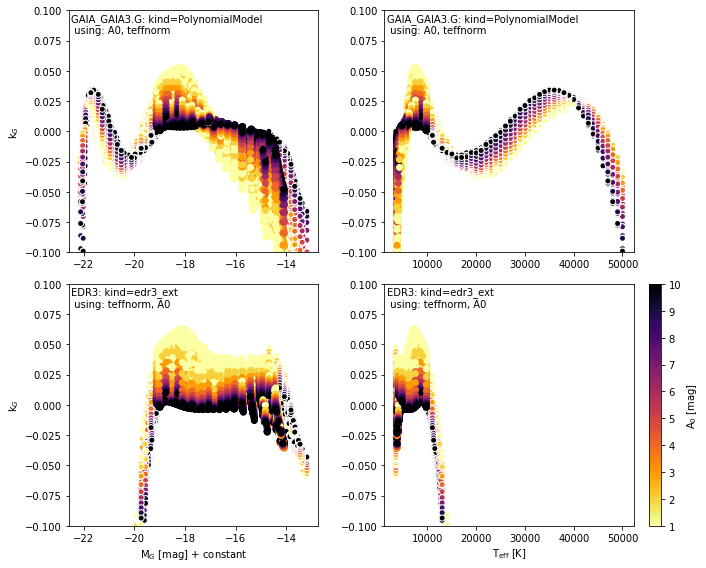

In [ ]:
import pandas as pd
from dustapprox import models
from dustapprox.literature import edr3
import pylab as plt

# get Gaia models
lib = models.PrecomputedModel()
# r_ = lib.find(passband='Gaia')[0]  # taking the first one
model = lib.load_model('../gaiadr3_a0_tmp.ecsv', passband='GAIA_GAIA3.G')

# get some data
data = pd.read_csv('../docs/models/precomputed/kurucs_gaiaedr3_small_a0_grid.csv')
df = data[(data['passband'] == 'GAIA_GAIA3.G') & (data['A0'] > 0)]

# values
ydata = (df['mag'] - df['mag0']) / df['A0']
kg_edr3 = edr3.edr3_ext().from_teff('kG', df['teff'], df['A0'])
delta_edr3 = ydata - kg_edr3
delta = ydata - model.predict(df)
# note: edr3 model valid for 3500 < teff < 10_000
selection = '3500 < teff < 10_000'
select = df.eval(selection)

plt.figure(figsize=(10, 8))
cmap = plt.cm.inferno_r

title = "{name:s}: kind={kind:s}\n using: {features}".format(
        name=model.name,
        kind=model.__class__.__name__,
        features=', '.join(model.feature_names))

kwargs_all = dict(rasterized=True, edgecolor='w', cmap=cmap, c=df['A0'])
kwargs_select = dict(rasterized=True, cmap=cmap, c=df['A0'][select])

ax0 = plt.subplot(221)
plt.scatter(df['mag0'], delta, **kwargs_all)
plt.scatter(df['mag0'][select], delta[select], **kwargs_select)
plt.colorbar().set_label(r'A$_0$ [mag]')
plt.ylabel(r'k$_G$')
plt.text(0.01, 0.99, title, fontsize='medium',
        transform=plt.gca().transAxes, va='top', ha='left')

ax1 = plt.subplot(222, sharey=ax0)
plt.scatter(df['teff'], delta, **kwargs_all)
plt.scatter(df['teff'][select], delta[select], **kwargs_select)
plt.colorbar().set_label(r'A$_0$ [mag]')
plt.text(0.01, 0.99, title, fontsize='medium',
        transform=plt.gca().transAxes, va='top', ha='left')

title = "{name:s}: kind={kind:s}\n using: {features}".format(
           name="EDR3",
           kind=edr3.edr3_ext().__class__.__name__,
           features=', '.join(('teffnorm', 'A0')))

ax = plt.subplot(223, sharex=ax0, sharey=ax0)
plt.scatter(df['mag0'], delta_edr3, **kwargs_all)
plt.scatter(df['mag0'][select], delta_edr3[select], **kwargs_select)
plt.colorbar().set_label(r'A$_0$ [mag]')
plt.xlabel(r'M$_G$ [mag] + constant')
plt.ylabel(r'k$_G$')
plt.ylim(-0.1, 0.1)
plt.text(0.01, 0.99, title, fontsize='medium',
        transform=plt.gca().transAxes, va='top', ha='left')


plt.subplot(224, sharex=ax1, sharey=ax1)
plt.scatter(df['teff'], delta_edr3, **kwargs_all)
plt.scatter(df['teff'][select], delta_edr3[select], **kwargs_select)
plt.xlabel(r'T$_{\rm eff}$ [K]')
plt.colorbar().set_label(r'A$_0$ [mag]')
plt.ylim(-0.1, 0.1)

plt.setp(plt.gcf().get_axes()[1:-1:2], visible=False)

plt.text(0.01, 0.99, title, fontsize='medium',
        transform=plt.gca().transAxes, va='top', ha='left')

plt.tight_layout()

```{seealso}

{mod}`dustapprox.literature` for other literature models.

{doc}`systematics` for more details.

```